SMS Spam Detection 

Classifier Models Used : 

    Support vector classifier
    
    Naive Bayes
    
    Decision Tree
    
    Logistic Regression
    
    Random Forest
     
Comparison Between Models has been done using :
    
    Accuracy and F1 Score
    
    Confusion Matrices
    
    Misclassified samples from SVM

Import Data and Module

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import string
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
%matplotlib inline

In [2]:
df = pd.read_csv('./input/spamhamiiitd.csv', encoding='latin-1')
df = df.loc[:,['v1','v2']]
df.tail()

,v1,v2
1995,spam,LUXURY REDEFINED BY ABW!LIFESTYLE Apartment in...
1996,spam,Luxury expandable Villas by Supertech in GNoid...
1997,spam,LUXURY COTTAGES & VILLAS at Jim Corbett JUNGLE...
1998,spam,Luxurious 2/3BHK apartments in BANNERGHATTA RO...
1999,spam,Weekend is almost here. Be it a movie a party...


Transforming first column `v1`, where `ham=0`, `spam=1`.

In [3]:
d={'spam':1,'ham':0}
df.v1 = list(map(lambda x:d[x],df.v1))

Conversion rom Text To Features

We have used tf-idf model on the text. The text will be 

1. lower: No captal appeared.
2. remove punctuation: No punctuation appeared.
3. stemmed: collect similar words (i.e. `words` will be transformed to `word`,etc.)

Then convert the cleaned text to tf-idf features (5000 features for an entry).

In [4]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

class stemmed_tfidf():
    def __init__(self,max_features=5000):
        self.ps = PorterStemmer()
        self.vc = TfidfVectorizer(analyzer='word',stop_words = 'english', max_features = max_features)
    def tfidf(self,ListStr):
        '''
        return: sklearn.feature_extraction.text.TfidfVectorizer
        '''
        table = self.vc.fit_transform([self.stem_string(s) for s in ListStr])
        return table
    def stem_string(self,s):
        '''
        s:str, e.g. s = "Get strings with string. With. Punctuation?"
        ps: stemmer from nltk module
        return: bag of words.e.g. 'get string with string with punctuat'
        '''    
        s = re.sub(r'[^\w\s]',' ',s)# remove punctuation.
        tokens = word_tokenize(s) 
        return ' '.join([self.ps.stem(w) for w in tokens])# e.g. 'desks'->'desk'

In [5]:
stf = stemmed_tfidf()
feature = stf.tfidf(df.v2) # this will be a sparse matrix of size (n,5000)

Prediction

In [6]:
print('%2.2f percent of data is spam'%round(100*sum(df.v1)/len(df),2))

50.00 percent of data is spam


In [7]:
Xtrain, Xtest, ytrain, ytest = train_test_split(feature, df.v1, test_size=0.2, random_state=1)

In [8]:
Acc = {}
F1score = {}
confusion_mat={}
predictions = {}

Support vector classifier

In [9]:
val_scores = []
listc = np.linspace(0.5,3,num=4)
listgamma = np.linspace(0.5,3,num=4)
kernel = ['rbf','sigmoid']# 'poly' is doing bad here, let's save some time.
for v in kernel:
    for c in listc:
        for gamma in listgamma:
            svc = SVC(kernel=v, C=c, gamma=gamma,class_weight='balanced')
            #3. The “balanced” mode uses the values of y to automatically adjust weights inversely 
            #   proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
            scores = cross_val_score(svc, Xtrain, ytrain,scoring='f1')
            val_scores.append([np.mean(scores),v, c,gamma])

In [10]:
val_scores = np.array(val_scores)
print('The best scores happens on:',val_scores[val_scores[:,0]==max(val_scores[:,0]),1:],
      ', where F1 =',val_scores[val_scores[:,0]==max(val_scores[:,0]),0])

The best scores happens on: [['rbf' '3.0' '0.5']] , where F1 = ['0.958332212744']


In [11]:
val_scores = []
listc = np.linspace(0.5,2,num=5)
listgamma = np.linspace(0.3,1,num=5)
for c in listc:
    for gamma in listgamma:
        svc = SVC(kernel='rbf', C=c, gamma=gamma,class_weight='balanced')
        scores = cross_val_score(svc, Xtrain, ytrain,scoring='f1')
        val_scores.append([np.mean(scores),v, c,gamma])
val_scores = np.array(val_scores)
print('The best scores happens on:',val_scores[val_scores[:,0]==max(val_scores[:,0]),1:],
      ', where F1 =',val_scores[val_scores[:,0]==max(val_scores[:,0]),0])

The best scores happens on: [['sigmoid' '1.625' '0.475']] , where F1 = ['0.957728294486']


In [12]:
name = 'SVM'
svc = SVC(kernel='sigmoid', C=1.625, gamma=0.475,class_weight='balanced')
svc.fit(Xtrain,ytrain)
pred = svc.predict(Xtest.toarray())
F1score[name]= f1_score(ytest,pred)
Acc[name] = accuracy_score(ytest,pred)
confusion_mat[name] = confusion_matrix(ytest,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

SVM: Accuracy=0.970, F1=0.970


2.2 Naive Bayes

In [13]:
GNB = GaussianNB()
GNB.fit(Xtrain.toarray(), ytrain)# Since our Xtrain is a sparse matrix, need to use .toarray() to convert it to dense one.
accuracy_score(ytest,GNB.predict(Xtest.toarray()))

0.91749999999999998

Using a better way, **multinominal Naive Bayes (MNB)**.

In [14]:
np.digitize([[0.1,0.22,0.33,0.8],[0.1,0.22,0.05,0.8]],bins = [.15,.25])

array([[0, 1, 2, 2],
       [0, 1, 0, 2]], dtype=int32)

In [15]:
bins = [.2,.4,.6,.8] # so every feature will end up 0,1,2,3,4
Xqtrain = np.digitize(Xtrain.toarray(),bins = bins)
Xqtest = np.digitize(Xtest.toarray(),bins = bins)

In [16]:
from sklearn.naive_bayes import MultinomialNB
val_scores = []
listalpha = np.linspace(0.01,1,num=20)
for i in listalpha:
    MNB = MultinomialNB(alpha=i)# alpha is Laplace smoothing parameter
    scores = cross_val_score(MNB, Xtrain, ytrain,scoring='f1')
    val_scores.append([np.mean(scores),i])
val_scores = np.array(val_scores)
print('The best scores happens on:',val_scores[val_scores[:,0]==max(val_scores[:,0]),1:],
      ', where F1 =',val_scores[val_scores[:,0]==max(val_scores[:,0]),0])

The best scores happens on: [[ 0.37473684]] , where F1 = [ 0.95712998]


In [17]:
name = 'MNB'
MNB = MultinomialNB(alpha=0.37473684)
MNB.fit(Xtrain,ytrain)
pred = MNB.predict(Xtest.toarray())
F1score[name]= f1_score(ytest,pred)
Acc[name] = accuracy_score(ytest,pred)
confusion_mat[name] = confusion_matrix(ytest,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

MNB: Accuracy=0.968, F1=0.968


This result is much better than using Gaussian NB.

Decision Tree

In [18]:
val_scores = []
for i in range(2,21):
    DT = DecisionTreeClassifier(min_samples_split=i, random_state=1,class_weight='balanced')
    scores = cross_val_score(DT, Xtrain, ytrain,scoring='f1')
    val_scores.append([np.mean(scores),i])
val_scores = np.array(val_scores)
print('The best scores happens on:',val_scores[val_scores[:,0]==max(val_scores[:,0]),1:],
      ', where F1 =',val_scores[val_scores[:,0]==max(val_scores[:,0]),0])

The best scores happens on: [[ 15.]
 [ 16.]
 [ 17.]
 [ 18.]] , where F1 = [ 0.88292555  0.88292555  0.88292555  0.88292555]


In [19]:
name = 'DT'
DT = DecisionTreeClassifier(min_samples_split=4, random_state=1,class_weight='balanced')
DT.fit(Xtrain,ytrain)
pred = DT.predict(Xtest.toarray())
F1score[name]= f1_score(ytest,pred)
Acc[name] = accuracy_score(ytest,pred)
confusion_mat[name] = confusion_matrix(ytest,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

DT: Accuracy=0.912, F1=0.912


Logistic Regression

In [20]:
list_C = np.linspace(0.1,3,num=20)
val_scores = []
for p in ('l1','l2'):
    for c in list_C:
        LR = LogisticRegression(penalty=p,C=c,class_weight='balanced')
        scores = cross_val_score(LR, Xtrain, ytrain,scoring='f1')
        val_scores.append([np.mean(scores),p,c])
val_scores = np.array(val_scores)
print('The best scores happens on:',val_scores[val_scores[:,0]==max(val_scores[:,0]),1:],
      ', where F1 =',val_scores[val_scores[:,0]==max(val_scores[:,0]),0])            

c:\users\abakl\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\abakl\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\abakl\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


The best scores happens on: [['l2' '2.84736842105']
 ['l2' '3.0']] , where F1 = ['0.953995474526' '0.953995474526']


In [21]:
name = 'LR'
LR = LogisticRegression(penalty='l2',C=3,class_weight='balanced')
LR.fit(Xtrain,ytrain)
pred = LR.predict(Xtest)
F1score[name]= f1_score(ytest,pred)
Acc[name] = accuracy_score(ytest,pred)
confusion_mat[name] = confusion_matrix(ytest,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

LR: Accuracy=0.970, F1=0.970


Random Forest

In [22]:
name = 'RF'
RF = RandomForestClassifier(n_estimators =80,class_weight ='balanced')
RF.fit(Xtrain,ytrain)
pred = RF.predict(Xtest)
F1score[name]= f1_score(ytest,pred)
Acc[name] = accuracy_score(ytest,pred)
confusion_mat[name] = confusion_matrix(ytest,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

RF: Accuracy=0.943, F1=0.942


Adaboost

In [23]:
name = 'AdaBoost'
Ada = AdaBoostClassifier(n_estimators=80, random_state=1)
Ada.fit(Xtrain,ytrain)
pred = Ada.predict(Xtest)
F1score[name]= f1_score(ytest,pred)
Acc[name] = accuracy_score(ytest,pred)
confusion_mat[name] = confusion_matrix(ytest,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

AdaBoost: Accuracy=0.925, F1=0.925


Comparison Between Models

In [24]:
'''import pickle
with open('spam_result.pickle', 'rb') as handle:
    b = pickle.load(handle)
Acc,F1score,confusion_mat,predictions = b[0],b[1],b[2],b[3]
'''

"import pickle\nwith open('spam_result.pickle', 'rb') as handle:\n    b = pickle.load(handle)\nAcc,F1score,confusion_mat,predictions = b[0],b[1],b[2],b[3]\n"

Accuracy and F1 Score

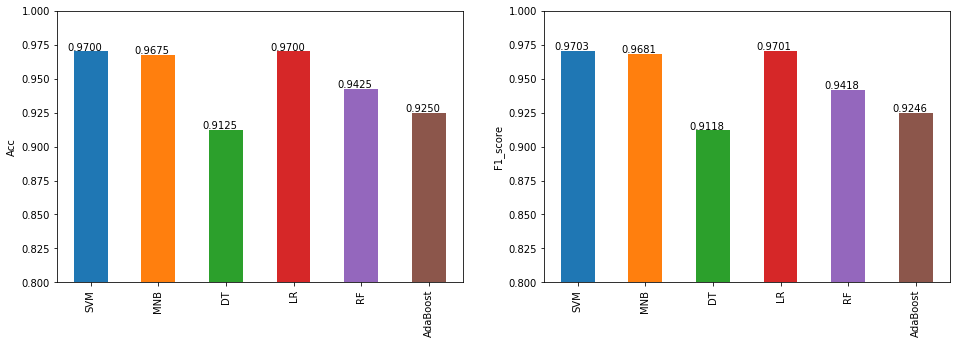

In [25]:
Results = pd.DataFrame([v for v in Acc.values()], columns = ['Acc'],
                    index = [k for k in Acc.keys()])
Results = Results.assign(F1_score=[v for v in F1score.values()])

fig = plt.figure(figsize=(16,5))
ylim = [[0.80,1],[0.8,1]]
x_offset = -0.35; y_offset = 0.001
for i,(a,yl) in enumerate(zip(list(Results.keys()),ylim)):
    plt.subplot(1,2,i+1)
    Results[a].plot(kind='bar')
    plt.ylabel(a); plt.ylim(yl)
    for p in plt.gca().patches:
        b = p.get_bbox()
        val = "{:1.4f}".format(b.y1 + b.y0)        
        plt.gca().annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))


Confusion Matrices

In [26]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout();plt.ylabel('True label');plt.xlabel('Predicted label')

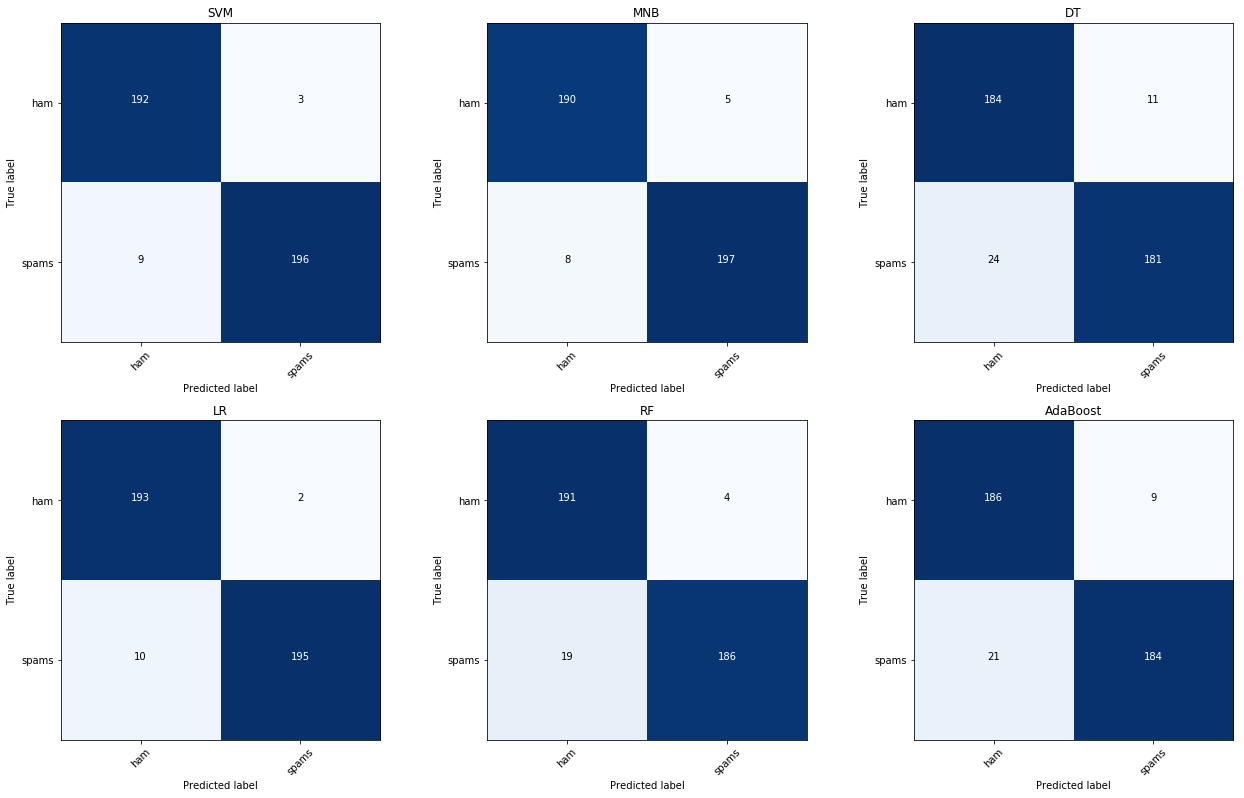

In [27]:
fig = plt.figure(figsize=(18,16))
i=1
for key,val in confusion_mat.items():
    plt.subplot(3,3,i);i+=1
    plot_confusion_matrix(val, classes=['ham','spams'], normalize=False,
                      title=key)

Misclassified samples from SVM

In [28]:
missclassified = np.nonzero(pred!=ytest)[0]
ind_miss = ytest.index[missclassified]
df.iloc[ind_miss,:]

,v1,v2
1210,1,RC44=Rs40 Talktime!Recharge with RC44 get Rs4...
1264,1,Word-a-Day Delineation- pictorial or verbal po...
1821,1,N to 54999
1678,1,NOW 50% off on AllReadymade Suits open all 7 ...
1437,1,Pantaloons greencard wishes you and your famil...
1342,1,Play it cool with all-new Spring Summer collec...
700,0,i knw meine bhi yahin galti ki thi..thoda scha...
478,0,i want to know when will your US internship be...
701,0,Indian Team Penalized by Animal Activists for ...
1231,1,Rare Opportunity in Delhi! Metroplex East. DD...
